# Regression From Origin

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product

import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as EuclideanDecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as EuclideanRandomForestRegressor

from src.hyperdt.toy_data import wrapped_normal_mixture
from src.hyperdt.conversions import convert
from src.hyperdt.tree import HyperbolicDecisionTreeRegressor, DecisionTreeRegressor, DecisionTreeClassifier
from src.hyperdt.forest import HyperbolicRandomForestRegressor

INFO: Using numpy backend


In [96]:
def euclidean_distance_from_origin(X):
    """Compute the euclidean distance from the origin for each row in X."""
    return np.sum(X ** 2, axis=1)

def poincare_distance_from_origin(X, eps=1e-5):
    """Compute the hyperbolic distance from the origin for each row in X in the
    Poincare ball model."""
    
    y = np.zeros(X.shape) # origin
    
    x_sqnorm = np.clip(np.sum(X * X, axis=-1), 0, 1 - eps)
    y_sqnorm = np.clip(np.sum(y * y, axis=-1), 0, 1 - eps)
    sqdist = np.sum(np.power(X - y, 2), axis=-1)
    frac = 1 + 2 * sqdist / ((1 - x_sqnorm) * (1 - y_sqnorm))
    poincare_distance = np.arccosh(frac)
    return poincare_distance

def hyperboloid_distance_from_origin(X, curvature=1, timelike_dim=0):
    """Compute the hyperbolic distance from the origin for each row in X in the
    hyperboloid model."""
    
    # Get X space and time components
    space_idxs = np.delete(np.arange(X.shape[1]), timelike_dim)
    X_space, X_time = X[:, space_idxs], X[:, timelike_dim, None]
    
    # Get origin space and time components
    origin_space = np.zeros(X_space.shape)
    origin_time = np.full_like(X_time, np.sqrt(1 / curvature))
    
    # Compute distance
    lorentzian_inner_product = (X_space @ origin_space.T - X_time @ origin_time.T).diagonal()
    hyperboloid_distance = np.sqrt(1 / curvature) * np.arccosh(-curvature * lorentzian_inner_product)
    return hyperboloid_distance

In [101]:
# check that the distance functions are correct
root_hyperboloid = [1, 0, 0, 0]
root_poincare = [0, 0, 0]

assert np.all(root_poincare == convert(root_hyperboloid, "hyperboloid", "poincare"))
assert np.all(root_hyperboloid == convert(root_poincare, "poincare", "hyperboloid"))

# check that the distance functions are correct
X_hyperboloid, _ = wrapped_normal_mixture(num_points=100, num_classes=4, noise_std=0.5, n_dim=2, seed=42)
X_poincare = convert(X_hyperboloid, "hyperboloid", "poincare")

hyperboloid_distance = hyperboloid_distance_from_origin(X_hyperboloid)
poincare_distance = poincare_distance_from_origin(X_poincare)

assert np.allclose(hyperboloid_distance, poincare_distance)

In [4]:
def get_distance_from_origin(n_samples=1000, n_classes=2, noise_std=0.5, n_dim=3, seed=None):
    """Get data for regression experiments."""
    
    # generate X
    X_hyperboloid, _ = wrapped_normal_mixture(
        num_points=n_samples, num_classes=n_classes, noise_std=noise_std, n_dim=n_dim, seed=seed
    )
    X_poincare = convert(X_hyperboloid, "hyperboloid", "poincare")
    
    data = {
        # ('poincare', 'euclidean'): (X_hyperboloid, euclidean_distance_from_origin(X_poincare)),
        # ('poincare', 'poincare'): (X_hyperboloid, poincare_distance_from_origin(X_poincare)),
        ('hyperboloid', 'euclidean'): (X_hyperboloid, euclidean_distance_from_origin(X_hyperboloid)),
        ('hyperboloid', 'hyperboloid'): (X_hyperboloid, hyperboloid_distance_from_origin(X_hyperboloid, curvature=1)),
    }
        
    return data

In [5]:
small = True

data_params = {
    'n_dim': [2],
    'seed': [42],
    'noise_std': [0.5],
    'n_samples': [1000],
    'n_classes': [2],
    }

model_params = {
    'max_depth': [3],
    'n_estimators': [64],
    'min_samples_split': [2],
}

if small:
    model_params['max_depth'] = [3]

In [6]:
params_dict = model_params | data_params
param_values_list = list(product(*params_dict.values()))
param_keys = list(params_dict.keys())
params_prod = [{key: val for key, val in zip(param_keys, param_values)} for param_values in param_values_list]
models = {
    'edt': ({}, EuclideanDecisionTreeRegressor),
    'hdt': ({}, HyperbolicDecisionTreeRegressor),
    'erf': ({'n_jobs': -1}, EuclideanRandomForestRegressor),
    'hrf': ({'n_jobs': -1}, HyperbolicRandomForestRegressor),
    }
result_list = []
data_list = []

with tqdm(params_prod) as pbar:
    for params in pbar:
        data = get_distance_from_origin(
            seed=params['seed'],
            n_dim=params['n_dim'],
            noise_std=params['noise_std'],
            n_samples=params['n_samples'],
            n_classes=params['n_classes'],
            )
        for (X_geometry, dist_func_name), (X, y) in data.items():
            pbar.set_description('Dim={}, Seed={}, max_depth={}'.format(
                params['n_dim'], params['seed'], params['max_depth']))
            
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=params['seed']
            )
            
            for model_name, (model_params, model) in models.items():
                try:
                    model = model(**(model_params | {'max_depth': params['max_depth']}))
                    model.fit(X_train, y_train)
                    mse = mean_squared_error(y_test, model.predict(X_test))
                except ValueError as e:
                    error_msg = str(e)
                    if 'Points must lie on a hyperboloid:' in error_msg: # error due to data not being on hyperboloid
                        mse = np.nan
                    else:
                        raise e

                # save results and data
                result = {
                    'model': model_name,
                    "X geometry": X_geometry,
                    "distance function": dist_func_name,
                } | params | {'mse': mse}
                result_list.append(result)
                data_list.append(data)

                
results = pd.DataFrame(result_list)

Dim=2, Seed=42, max_depth=3: 100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


In [7]:
results

,model,X geometry,distance function,max_depth,n_estimators,min_samples_split,n_dim,seed,noise_std,n_samples,n_classes,mse
0,edt,hyperboloid,euclidean,3,64,2,2,42,0.5,1000,2,4.528372e+00
1,hdt,hyperboloid,euclidean,3,64,2,2,42,0.5,1000,2,4.945373e+01
2,erf,hyperboloid,euclidean,3,64,2,2,42,0.5,1000,2,1.186442e+00
3,hrf,hyperboloid,euclidean,3,64,2,2,42,0.5,1000,2,1.083856e+02
4,edt,hyperboloid,hyperboloid,3,64,2,2,42,0.5,1000,2,1.913117e-08
5,hdt,hyperboloid,hyperboloid,3,64,2,2,42,0.5,1000,2,2.089139e-07
6,erf,hyperboloid,hyperboloid,3,64,2,2,42,0.5,1000,2,4.979469e-09
7,hrf,hyperboloid,hyperboloid,3,64,2,2,42,0.5,1000,2,8.900003e-07


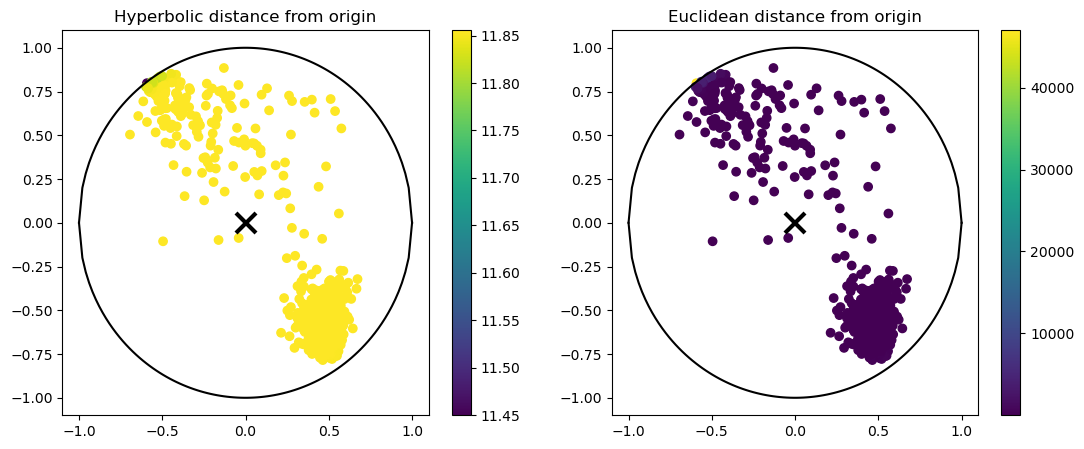

In [47]:
import matplotlib.pyplot as plt
# Plot

data = get_distance_from_origin(
            seed=44,
            n_dim=2,
            noise_std=0.5,
            n_samples=1000,
            n_classes=2,
            )

_, y_hyp = data[('hyperboloid', 'hyperboloid')]
X, y_ecl = data[('hyperboloid', 'euclidean')]

X_poincare = convert(X, "hyperboloid", "poincare")

fig, axs = plt.subplots(figsize=(13, 5), ncols=2)
mappable = axs[0].scatter(X_poincare[:, 0], X_poincare[:, 1], c=y_hyp, cmap='viridis')
plt.colorbar(mappable)
mappable = axs[1].scatter(X_poincare[:, 0], X_poincare[:, 1], c=y_ecl, cmap='viridis')
plt.colorbar(mappable)

for ax in axs:
    _x = np.linspace(-1, 1, 100)
    _y = np.sqrt(1 - _x ** 2)
    ax.plot(_x, _y, c="black")
    ax.plot(_x, -_y, c="black")
    ax.plot([0], [0], marker="x", c="black", markersize=15, markeredgewidth=3)

axs[0].set_title("Hyperbolic distance from origin")
axs[1].set_title("Euclidean distance from origin")    
fig.show()

In [49]:
X, y = data[(('hyperboloid', 'hyperboloid'))]
y

array([11.85497927, 11.85497745, 11.85536762, 11.85523091, 11.85501018,
       11.85557066, 11.85513417, 11.85549618, 11.8554587 , 11.85539374,
       11.85538672, 11.85555682, 11.85512517, 11.85537435, 11.85511105,
       11.8555439 , 11.85548378, 11.85532179, 11.85536928, 11.8552143 ,
       11.85538444, 11.85530142, 11.85526952, 11.85531722, 11.85551464,
       11.85550801, 11.85539007, 11.85463345, 11.85547872, 11.8534154 ,
       11.85521208, 11.85552986, 11.85518262, 11.85538594, 11.8553509 ,
       11.85549345, 11.85557212, 11.85550107, 11.85531641, 11.85488201,
       11.85533344, 11.85557113, 11.85556818, 11.85535582, 11.85446308,
       11.85550948, 11.85504849, 11.85512086, 11.85527165, 11.85543344,
       11.85544792, 11.8554149 , 11.85550819, 11.85556786, 11.85546043,
       11.85465728, 11.85555407, 11.8551182 , 11.85555606, 11.85522514,
       11.85524973, 11.85514885, 11.85554125, 11.85525755, 11.85499013,
       11.85439354, 11.85547587, 11.8555331 , 11.8553817 , 11.85

### Save Results

In [8]:
save_results = False

In [9]:
from pathlib import Path 
import pickle

if save_results:

    results_path = Path('results/origin_distance_mse.tsv')
    data_path = Path('results/origin_distance_data.pkl')
    if not results_path.parent.exists():
        results_path.parent.mkdir(parents=True)
        
    results.to_csv(sep='\t', path_or_buf=results_path, index=False)
    with open(data_path, 'wb') as f:
        pickle.dump(data_list, f)

In [10]:
# read results back in for sanity check

if save_results:
    results = pd.read_csv(results_path, sep='\t')
    results